In [137]:
! pip install transformers
! pip install datasets

You should consider upgrading via the 'd:\programas\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\programas\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import tensorflow as tf
from sklearn.utils import class_weight 
import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import yaml

In [2]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])

In [4]:
base = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)
base.head()

,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [4]:
base.drop(columns=['image_name', 'humour', 'sarcasm','offensive','motivational'], inplace=True)
base.head()

,text,target
0,if you want to view paradis simpli look around...,positive
1,if i had a brick for everi lie hillari told i ...,positive
2,that thing over there can i eat that,very_positive
3,my dad point to liam and said when did david b...,neutral
4,probabl the first man to do year challeng chen...,negative


#### Considerando somente as labels 'negative', 'neutral' e 'positive'.

In [5]:
base.target.replace("very_positive", 
           "positive", 
           inplace=True)
base.target.replace("very_negative", 
           "negative", 
           inplace=True)    
NUM_LABELS = len(base.target.unique())
base.target = base.target.astype('category').cat.codes

base.head()

,text,target
0,if you want to view paradis simpli look around...,2
1,if i had a brick for everi lie hillari told i ...,2
2,that thing over there can i eat that,2
3,my dad point to liam and said when did david b...,1
4,probabl the first man to do year challeng chen...,0


In [6]:
train, val = train_test_split(base, test_size=0.2, random_state=SEED)
print(train.shape, val.shape)

(4362, 2) (1091, 2)


In [7]:
dataset_train = Dataset.from_pandas(train, preserve_index=False)
dataset_val = Dataset.from_pandas(val, preserve_index=False)

In [145]:
dataset_train

Dataset({
    features: ['text', 'target'],
    num_rows: 4362
})

In [146]:
dataset_val

Dataset({
    features: ['text', 'target'],
    num_rows: 1091
})

# Utilização dos transformers

In [147]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [148]:
def tokenize_function(sample):
  return tokenizer(sample["text"])

tokenized_dataset_train = dataset_train.map(tokenize_function)
tokenized_dataset_val = dataset_val.map(tokenize_function)

  0%|          | 0/4362 [00:00<?, ?ex/s]

  0%|          | 0/1091 [00:00<?, ?ex/s]

In [149]:
tokenized_dataset_train

Dataset({
    features: ['text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4362
})

In [150]:
tokenized_dataset_val

Dataset({
    features: ['text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1091
})

In [151]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [152]:
tf_train_dataset = tokenized_dataset_train.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

In [153]:
tf_val_dataset = tokenized_dataset_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [154]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
class BalancedSparseCategoricalAccuracy(keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [156]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[BalancedSparseCategoricalAccuracy()]
)
model.summary()

Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_227 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [157]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(train.target) ,y = train.target).ravel()
class_weights = dict((i,v) for i, v in enumerate(weights))
class_weights

{0: 3.5901234567901232, 1: 1.0699043414275202, 2: 0.5596612779060816}

In [158]:
model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=10, class_weight = class_weights)

Epoch 1/10
546/546 [==============================] - 1087s 2s/step - loss: 1.1087 - balanced_sparse_categorical_accuracy: 0.3387 - val_loss: 1.0852 - val_balanced_sparse_categorical_accuracy: 0.3500
Epoch 2/10
546/546 [==============================] - 1114s 2s/step - loss: 1.0885 - balanced_sparse_categorical_accuracy: 0.3791 - val_loss: 1.1292 - val_balanced_sparse_categorical_accuracy: 0.3089
Epoch 3/10
546/546 [==============================] - 1117s 2s/step - loss: 1.0253 - balanced_sparse_categorical_accuracy: 0.4424 - val_loss: 1.1493 - val_balanced_sparse_categorical_accuracy: 0.3112
Epoch 4/10
546/546 [==============================] - 1080s 2s/step - loss: 0.8227 - balanced_sparse_categorical_accuracy: 0.5835 - val_loss: 1.0161 - val_balanced_sparse_categorical_accuracy: 0.3447
Epoch 5/10
546/546 [==============================] - 1081s 2s/step - loss: 0.5737 - balanced_sparse_categorical_accuracy: 0.7169 - val_loss: 1.2015 - val_balanced_sparse_categorical_accuracy: 0.3475


In [159]:
preds = model.predict(tf_val_dataset, verbose=1)
preds

137/137 [==============================] - 85s 596ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[-1.9628214 , -2.2423775 ,  3.4195797 ],
       [-3.9515567 ,  0.67654884,  2.9428566 ],
       [-3.4571269 ,  2.5008001 ,  1.1239804 ],
       ...,
       [-4.013348  ,  3.6279957 ,  0.74270785],
       [-3.51136   ,  1.8514698 ,  1.7262945 ],
       [-3.2769241 ,  0.7124794 ,  2.3186903 ]], dtype=float32), hidden_states=None, attentions=None)

In [167]:
loss, accuracy = model.evaluate(tf_val_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

137/137 [==============================] - 85s 621ms/step - loss: 2.0996 - balanced_sparse_categorical_accuracy: 0.3616
Loss: 2.0996181964874268
Accuracy: 0.3615765869617462


In [168]:
loss, accuracy = model.evaluate(tf_train_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

546/546 [==============================] - 317s 581ms/step - loss: 0.0818 - balanced_sparse_categorical_accuracy: 0.9841
Loss: 0.08179384469985962
Accuracy: 0.984078049659729


In [160]:
preds['logits']

array([[-1.9628214 , -2.2423775 ,  3.4195797 ],
       [-3.9515567 ,  0.67654884,  2.9428566 ],
       [-3.4571269 ,  2.5008001 ,  1.1239804 ],
       ...,
       [-4.013348  ,  3.6279957 ,  0.74270785],
       [-3.51136   ,  1.8514698 ,  1.7262945 ],
       [-3.2769241 ,  0.7124794 ,  2.3186903 ]], dtype=float32)

In [161]:
tf.nn.softmax(preds['logits']).numpy()

array([[4.5599621e-03, 3.4478747e-03, 9.9199218e-01],
       [9.1737544e-04, 9.3865857e-02, 9.0521681e-01],
       [2.0600301e-03, 7.9683483e-01, 2.0110512e-01],
       ...,
       [4.5458114e-04, 9.4668382e-01, 5.2861612e-02],
       [2.4841274e-03, 5.2993333e-01, 4.6758258e-01],
       [3.0838910e-03, 1.6659997e-01, 8.3031619e-01]], dtype=float32)

# Salvando o modelo

In [162]:
#model.save_weights(PATH_TO_WEIGHTS + model_name + '.hdf5')
#model.save_pretrained(PATH_TO_MODELS + model_name)

# Validação com a acurácia balanceada!

In [8]:
model_name = "bert-base-uncased"

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.load_weights(PATH_TO_WEIGHTS + model_name + '.hdf5')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def tokenize_function(sample):
  return tokenizer(sample["text"])

dataset_val = Dataset.from_pandas(val, preserve_index=False)
tokenized_dataset_val = dataset_val.map(tokenize_function)

Parameter 'function'=<function tokenize_function at 0x00000180122EB268> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1091 [00:00<?, ?ex/s]

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
tf_val_dataset = tokenized_dataset_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [14]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[BalancedSparseCategoricalAccuracy()]
)

In [15]:
preds = model.predict(tf_val_dataset, verbose=3)
preds

TFSequenceClassifierOutput(loss=None, logits=array([[-1.9628214 , -2.2423775 ,  3.4195797 ],
       [-3.9515567 ,  0.67654884,  2.9428566 ],
       [-3.4571269 ,  2.5008001 ,  1.1239804 ],
       ...,
       [-4.013348  ,  3.6279957 ,  0.74270785],
       [-3.51136   ,  1.8514698 ,  1.7262945 ],
       [-3.2769241 ,  0.7124794 ,  2.3186903 ]], dtype=float32), hidden_states=None, attentions=None)

In [16]:
prob = tf.nn.softmax(preds['logits']).numpy()
y_pred = np.argmax(prob, axis=1)

In [17]:
print("Val - balanced_accuracy : ", balanced_accuracy_score(val.target,  y_pred))
print("Val - F1 : ", f1_score(val.target, y_pred, average='macro'))

Val - balanced_accuracy :  0.313025820936663
Val - F1 :  0.302142979279197


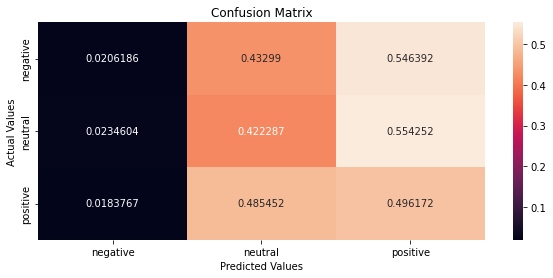

In [18]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(val.target, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()